In [1]:
%matplotlib widget

In [1]:
%cd ..

/home/jupyter-vhirtham/weldx/weldx


In [2]:
# necesessary packages
import numpy as np

import matplotlib.pyplot as plt
import pandas as pd
import weldx.transformations as tf
import weldx.visualization as vs
import xarray as xr
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import
from copy import deepcopy

# Introduction

This tutorial is about the `CoordinateSystemManager` class of the `weldx.transformations` package. It builds upon the tutorial about coordinate systems (tutorials/transformations_01_coordinate_systems.ipynb).

The purpose of the `CoordinateSystemManager` is to define and manage the relationships of different coordinate systems and their associated data in a tree-like data structure. It provides methods to transform a `LocalCoordinateSystem` or its data to an arbitrary other coordinate system.

# Construct and add coordinate systems

The constructor of `CoordinateSystemManager` requires the name of the root coordinate system as parameter. 

In [3]:
csm = tf.CoordinateSystemManager("root")

> **Hint:** The name of a coordinate systems can be any hashable type even though it is advised to use strings.

Further coordinate systems can be added with the `add_cs` member function of the `CoordinateSystemManager`. It expects 3 parameters. The first parameter is the name of the new coordinate system. The second parameter is the name of an already existing coordinate system in which is the reference system of the new one. The third parameter is a `weldx.transformations.LocalCoordinateSystem` that describes the position and orientation of the new coordinate system in its reference system. Additionally, the `CoordinateSystemManager` provides some functions that create the `LocalCoordinateSystem` internally. The method `create_cs` takes the name of the new coordinate system and its reference system as first two parameters. The remaining parameters and their default values are identical to the ones from the `LocalCoordinateSystem.__init__` method. Similarly, there are functions for each of the ´LocalCoordinateSystem´s construction/factory methods (`from_euler`, `from_xyz`, etc.). The naming is simply `create_cs_` plus the name of the corresponding function of the `LoocalCoordinateSystem`. For example `construct_cs_from_euler`. Let's add some coordinate systems using different methods:

In [4]:
lcs_specimen_in_root = tf.LocalCoordinateSystem(coordinates=[0, 1, -2])

csm.create_cs_from_euler(
    "flange", "root", sequence="x", angles=20, degrees=True, coordinates=[-1, -1, 2]
)
csm.create_cs("torch", "flange", coordinates=[0, 0, -1])
csm.add_cs("specimen", "root", lcs_specimen_in_root)

# Transform coordinate systems to another reference system

After all coordinate systems are added to the `CoordinateSystemManager`, getting a coordinate system in relation to any other reference system in form of a `LocalCoordinateSystem` class is quite easy. Simply call `get_local_coordinate_system`. The name of the system that should be transformed is passed to the function as first parameter. The second parameter is the name of the target reference system. If it is omitted, the parent system is used as reference.

In [5]:
lcs_torch_in_root = csm.get_local_coordinate_system("torch", "root")
lcs_flange_in_root = csm.get_local_coordinate_system("flange")
lcs_specimen_in_root = csm.get_local_coordinate_system("specimen")

lcs_root_in_torch = csm.get_local_coordinate_system("root", "torch")
lcs_flange_in_torch = csm.get_local_coordinate_system("flange", "torch")
lcs_specimen_in_torch = csm.get_local_coordinate_system("specimen", "torch")

The following plots show the different systems in the root coordinate system and in the torch coordinate system:

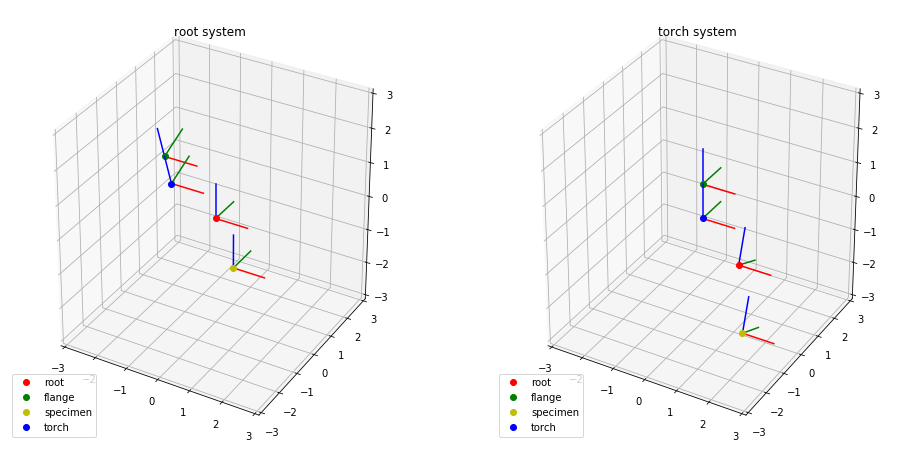

In [6]:
lcs_root_in_root = tf.LocalCoordinateSystem()
lcs_torch_in_torch = tf.LocalCoordinateSystem()

# plot coordinate systems
fig_01 = plt.figure()
fig_01.set_size_inches(16, 8)
gs_01 = fig_01.add_gridspec(1, 2)
ax_0_01 = fig_01.add_subplot(gs_01[0, 0], projection="3d")
ax_1_01 = fig_01.add_subplot(gs_01[0, 1], projection="3d")

# first plot
vs.plot_coordinate_system(lcs_root_in_root, ax_0_01, color="r", label="root")
vs.plot_coordinate_system(lcs_flange_in_root, ax_0_01, color="g", label="flange")
vs.plot_coordinate_system(lcs_specimen_in_root, ax_0_01, color="y", label="specimen")
vs.plot_coordinate_system(lcs_torch_in_root, ax_0_01, color="b", label="torch")
ax_0_01.set_xlim([-3, 3])
ax_0_01.set_ylim([-3, 3])
ax_0_01.set_zlim([-3, 3])
ax_0_01.set_title("root system")
ax_0_01.legend(loc="lower left")  #


# second plot
vs.plot_coordinate_system(lcs_root_in_torch, ax_1_01, color="r", label="root")
vs.plot_coordinate_system(lcs_flange_in_torch, ax_1_01, color="g", label="flange")
vs.plot_coordinate_system(lcs_specimen_in_torch, ax_1_01, color="y", label="specimen")
vs.plot_coordinate_system(lcs_torch_in_torch, ax_1_01, color="b", label="torch")
ax_1_01.set_xlim([-3, 3])
ax_1_01.set_ylim([-3, 3])
ax_1_01.set_zlim([-3, 3])
ax_1_01.set_title("torch system")
ax_1_01.legend(loc="lower left")

# Assignment and transformation of spatial data

A coordinate system stored in the `CoordinateSystemManager` can also get spatial data assigned to it. For example, this might be a sensor positions or geometry data in form of a point clouds. In this case it becomes the data's reference system and all values refer to its coordinate origin. 

Data can be assigned to a coordinate system with the `assign_data` function. It expects 3 parameters. The first one is the actual data. Currently, `xarray.DataArray` is the only supported type. The second parameter is a name of the data and the third one the name of the coordinate system that the data belongs to. In the following lines we define and assign some data to the `CoordinateSystemManager`.

In [7]:
sensor_positions_in_root = xr.DataArray(
    [[0, -1, 0], [0, -2, 0]], dims=["n", "c"], coords={"c": ["x", "y", "z"]}
)

specimen_geometry_in_specimen = xr.DataArray(
    [
        [0, 1, 0],
        [1, 1, 0],
        [2, 1, 0],
        [0, 2, 0],
        [1, 2, 0],
        [2, 2, 0],
        [0, 3, 0],
        [1, 3, 0],
        [2, 3, 0],
        [0, 4, 0],
        [1, 4, 0],
        [2, 4, 0],
    ],
    dims=["n", "c"],
    coords={"c": ["x", "y", "z"]},
)

csm.assign_data(sensor_positions_in_root, "sensors", "root")
csm.assign_data(specimen_geometry_in_specimen, "specimen geometry", "specimen")

With the `get_data` function, the unmodified data can be retrieved from the `CoordinateSystemManager` using its name as first parameter. 

In [8]:
assert specimen_geometry_in_specimen.identical(csm.get_data("specimen geometry"))

The optional second parameter can be used to get the data transformed into any of the `CoordinateSystemManager`s coordinate systems. You just need to specify the desired target coordinate systems name:

In [9]:
specimen_geometry_in_root = csm.get_data("specimen geometry", "root")

sensor_positions_in_torch = csm.get_data("sensors", "torch")
specimen_geometry_in_torch = csm.get_data("specimen geometry", "torch")

Here is a plot of the specified data in the root and torch coordinate system.

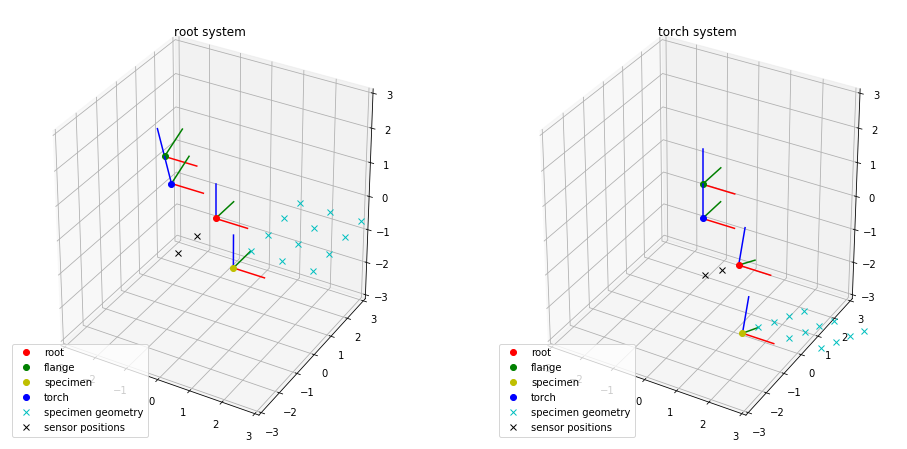

In [10]:
lcs_root_in_root = tf.LocalCoordinateSystem()
lcs_torch_in_torch = tf.LocalCoordinateSystem()

# plot coordinate systems
fig_02 = plt.figure()
fig_02.set_size_inches(16, 8)
gs_02 = fig_02.add_gridspec(1, 2)
ax_0_02 = fig_02.add_subplot(gs_02[0, 0], projection="3d")
ax_1_02 = fig_02.add_subplot(gs_02[0, 1], projection="3d")

# first plot
vs.plot_coordinate_system(lcs_root_in_root, ax_0_02, color="r", label="root")
vs.plot_coordinate_system(lcs_flange_in_root, ax_0_02, color="g", label="flange")
vs.plot_coordinate_system(lcs_specimen_in_root, ax_0_02, color="y", label="specimen")
vs.plot_coordinate_system(lcs_torch_in_root, ax_0_02, color="b", label="torch")
ax_0_02.plot(
    specimen_geometry_in_root[:, 0],
    specimen_geometry_in_root[:, 1],
    specimen_geometry_in_root[:, 2],
    "xc",
    label="specimen geometry",
)
ax_0_02.plot(
    sensor_positions_in_root[:, 0],
    sensor_positions_in_root[:, 1],
    sensor_positions_in_root[:, 2],
    "xk",
    label="sensor positions",
)


ax_0_02.set_xlim([-3, 3])
ax_0_02.set_ylim([-3, 3])
ax_0_02.set_zlim([-3, 3])
ax_0_02.set_title("root system")
ax_0_02.legend(loc="lower left")  #


# second plot
vs.plot_coordinate_system(lcs_root_in_torch, ax_1_02, color="r", label="root")
vs.plot_coordinate_system(lcs_flange_in_torch, ax_1_02, color="g", label="flange")
vs.plot_coordinate_system(lcs_specimen_in_torch, ax_1_02, color="y", label="specimen")
vs.plot_coordinate_system(lcs_torch_in_torch, ax_1_02, color="b", label="torch")
ax_1_02.plot(
    specimen_geometry_in_torch[:, 0],
    specimen_geometry_in_torch[:, 1],
    specimen_geometry_in_torch[:, 2],
    "xc",
    label="specimen geometry",
)
ax_1_02.plot(
    sensor_positions_in_torch[:, 0],
    sensor_positions_in_torch[:, 1],
    sensor_positions_in_torch[:, 2],
    "xk",
    label="sensor positions",
)
ax_1_02.set_xlim([-3, 3])
ax_1_02.set_ylim([-3, 3])
ax_1_02.set_zlim([-3, 3])
ax_1_02.set_title("torch system")
ax_1_02.legend(loc="lower left")

It is not necessary to attach data to a coordinate system to transform it to another one. The `CoordinateSystemManager` also provides the `transform_data` function for this purpose. It expects 3 parameters. The first parameter is the actual data and must be a `numpy.ndarray` or an `xarray.DataArray`. The second one is the source system name and the third one the target systems' name:

In [11]:
assert csm.transform_data(specimen_geometry_in_specimen, "specimen", "root").identical(
    specimen_geometry_in_root
)

## Time dependencies

As described in the previous tutorial about the `LocalCoordinateSystem` class, the orientation of a coordinate system towards its reference system might vary in time. Form the API side, time dependent coordinate systems are not treated any different than constant coordinate systems. However, the `get_local_coordinate_system` function needs to perform some time interpolations internally if the timestamps of all involved coordinate systems aren't identical. You might wonder which timestamps the resulting interpolated `LocalCoordinateSystem` possesses. The default behavior is that its timestamps are the time union of all coordinate systems participating in the transformation. However, you can also provide the desired timestamps as a `pandas.DatetimeIndex` object using the `time` parameter of the `get_local_coordinate_system` function. Another method is to pass the name of a coordinate system that should provide the timestamps to the `time` parameter.

Let's define a new `CoordinateSystemManager` to demonstrate the different approaches:

In [12]:
parent_time = ["2020-01-01", "2020-01-06"]
parent_coords = [[1, -1, 0], [0, -1, 0]]
parent_orientation = tf.rotation_matrix_z([0, np.pi / 2])

child_time = ["2020-01-02", "2020-01-05"]
child_coords = [0, 2, 0]
child_orientation = tf.rotation_matrix_z([0, np.pi / 2])


childchild_time = ["2020-01-03", "2020-01-04"]
childchild_coords = [2, 0, 0]
childchild_orientation = tf.rotation_matrix_z([0, np.pi / 2])


csm_tdp = tf.CoordinateSystemManager("root")
csm_tdp.create_cs(
    "parent",
    "root",
    coordinates=parent_coords,
    orientation=parent_orientation,
    time=parent_time,
)
csm_tdp.create_cs(
    "child",
    "parent",
    coordinates=child_coords,
    orientation=child_orientation,
    time=child_time,
)
csm_tdp.create_cs(
    "child child",
    "child",
    coordinates=childchild_coords,
    orientation=childchild_orientation,
    time=childchild_time,
)

Now we request from the `CoordinateSystemManager` to transform all coordinate systems to the `"root"` system: 

In [13]:
# default
lcs_parent_in_root_default = csm_tdp.get_local_coordinate_system("parent")
lcs_child_in_root_default = csm_tdp.get_local_coordinate_system("child", "root")
lcs_childchild_in_root_default = csm_tdp.get_local_coordinate_system(
    "child child", "root"
)

# specific times
time = pd.date_range("01-01-2020", periods=10, freq="12H")
lcs_parent_in_root_time = csm_tdp.get_local_coordinate_system("parent", time=time)
lcs_child_in_root_time = csm_tdp.get_local_coordinate_system("child", "root", time=time)
lcs_childchild_in_root_time = csm_tdp.get_local_coordinate_system(
    "child child", "root", time=time
)

# reference system
lcs_parent_in_root_ref = csm_tdp.get_local_coordinate_system("parent", time="parent")
lcs_child_in_root_ref = csm_tdp.get_local_coordinate_system(
    "child", "root", time="parent"
)
lcs_childchild_in_root_ref = csm_tdp.get_local_coordinate_system(
    "child child", "root", time="parent"
)

Here is a plot showing the different results:

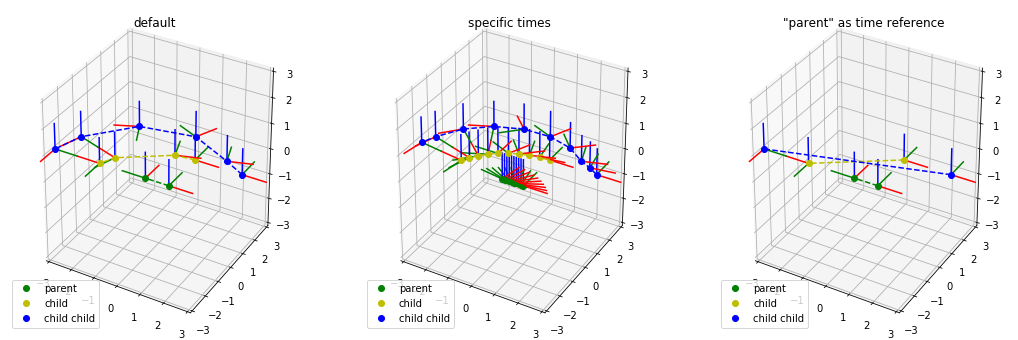

In [14]:
def plot_time_dependent_coordinate_system(lcs, name, color, ax):
    coords = []
    for i in range(len(lcs.time)):
        label = None
        if i == 0:
            label = name
        vs.plot_coordinate_system(lcs, ax, color=color, label=label, time_idx=i)
        coords.append(lcs.coordinates[i].data)

    line_params = "--" + color
    coords = np.array(coords)
    ax.plot(coords[:, 0], coords[:, 1], coords[:, 2], line_params)


def plot_all_interpolated_coordinate_systems(
    lcs_parent, lcs_child, lcs_childchild, title, ax
):
    plot_time_dependent_coordinate_system(lcs_parent, "parent", "g", ax)
    plot_time_dependent_coordinate_system(lcs_child, "child", "y", ax)
    plot_time_dependent_coordinate_system(lcs_childchild, "child child", "b", ax)

    ax.set_xlim([-3, 3])
    ax.set_ylim([-3, 3])
    ax.set_zlim([-3, 3])
    ax.set_title(title)
    ax.legend(loc="lower left")


fig_tdp = plt.figure()
fig_tdp.set_size_inches(18, 6)
gs_tdp = fig_tdp.add_gridspec(1, 3)
ax_0_tdp = fig_tdp.add_subplot(gs_tdp[0, 0], projection="3d")
ax_1_tdp = fig_tdp.add_subplot(gs_tdp[0, 1], projection="3d")
ax_2_tdp = fig_tdp.add_subplot(gs_tdp[0, 2], projection="3d")


plot_all_interpolated_coordinate_systems(
    lcs_parent_in_root_default,
    lcs_child_in_root_default,
    lcs_childchild_in_root_default,
    "default",
    ax_0_tdp,
)

plot_all_interpolated_coordinate_systems(
    lcs_parent_in_root_time,
    lcs_child_in_root_time,
    lcs_childchild_in_root_time,
    "specific times",
    ax_1_tdp,
)

plot_all_interpolated_coordinate_systems(
    lcs_parent_in_root_ref,
    lcs_child_in_root_ref,
    lcs_childchild_in_root_ref,
    '"parent" as time reference',
    ax_2_tdp,
)

The `CoordinateSystemManager` also has a `interp_time` method. By default, this will return a new instance where every coordinate system is interpolate to match the timestamps provided as first function parameter. Optionally, one can pass a list of coordinate system names that should be interpolated as second parameter. Coordinate systems that are not in the list remain unchanged. One can also choose to perform the operations "in place" modifying the current instance of the `CoordinateSystemManager`. Therefore, the third parameter `in_place` has to be set to `True`.

In [15]:
time_new = pd.date_range("01-01-2020", periods=3, freq="2D")

# default interpolation -------------------------
csm_tdp_interp = csm_tdp.interp_time(time_new)

assert np.all(csm_tdp_interp.get_local_coordinate_system("parent").time == time_new)
assert np.all(csm_tdp_interp.get_local_coordinate_system("child").time == time_new)
assert np.all(
    csm_tdp_interp.get_local_coordinate_system("child child").time == time_new
)

# selective interpolation -----------------------
csm_tdp_interp = csm_tdp.interp_time(time_new, ["child", "child child"])

assert np.all(
    csm_tdp_interp.get_local_coordinate_system("parent").time
    == csm_tdp.get_local_coordinate_system("parent").time
)
assert np.all(csm_tdp_interp.get_local_coordinate_system("child").time == time_new)
assert np.all(
    csm_tdp_interp.get_local_coordinate_system("child child").time == time_new
)

# in place interpolation ------------------------
csm_tdp_interp = deepcopy(csm_tdp)
csm_tdp_interp.interp_time(time_new, in_place=True)

assert np.all(csm_tdp_interp.get_local_coordinate_system("parent").time == time_new)
assert np.all(csm_tdp_interp.get_local_coordinate_system("child").time == time_new)
assert np.all(
    csm_tdp_interp.get_local_coordinate_system("child child").time == time_new
)



> **TODO** 
- Time dependent data